In [138]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, stft, lfilter, get_window, windows
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.io import loadmat

In [3]:
# =============================================
# 1. 选择天线
# =============================================
def select_antenna(csi_data):
    assert len(csi_data.shape)==3, "csi_data must be 3-dimension (Num_Time, Num_Antennas, Num_Subscribers)"
    mean = np.mean(csi_data, axis=0)
    variance = np.var(csi_data, axis=0)
    mean_var_ratio = np.sum(mean/variance, axis=1)
    max_index = np.argmax(mean_var_ratio)
    min_index = np.argmin(mean_var_ratio)
    return csi_data[:, max_index, :], csi_data[:, min_index, :]

csi_data = loadmat('../CSI-Data-Fu/user1-1-1-1-1-r2.mat')['csi_data']
static_csi, dynamic_csi = select_antenna(csi_data.reshape(-1, 3, 30))

In [4]:
# =============================================
# 2. 共轭乘法去除随机相位偏移（式2）
# =============================================
def conjugate_multiply(csi1, csi2):
    """对两路天线的CSI进行共轭相乘"""
    return csi1 * np.conj(csi2)

H_conj = conjugate_multiply(static_csi, dynamic_csi)  # 输出形状 (1000, 57)

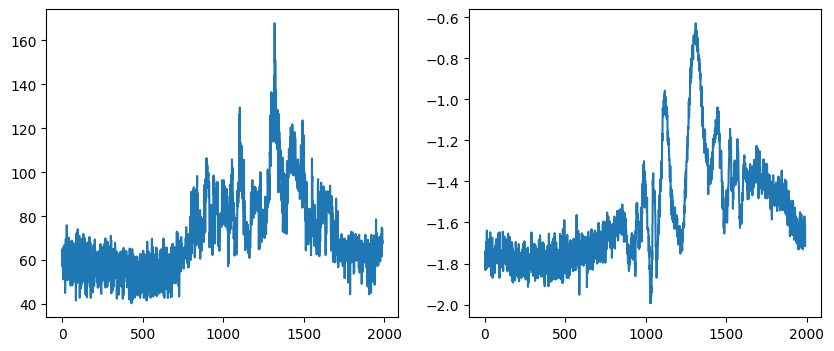

In [102]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(np.abs(H_conj[:,0]))

plt.subplot(1,2,2)
plt.plot(np.angle(H_conj[:,0]))

In [126]:
# =============================================
# 3. Butterworth带通滤波（去除高频噪声）
# =============================================
def butter_bandpass_filter(data, lowcut=3, highcut=60, fs=1000, order=5):
    """Butterworth带通滤波"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return filtfilt(b, a, data, axis=0)

# 假设采样率fs=100Hz，滤波范围0.5-5Hz（人体运动频率）
H_filtered = butter_bandpass_filter(H_conj, lowcut=0.5, highcut=60, fs=1000)
H_filtered = H_filtered*np.exp(1j*np.angle(H_conj))


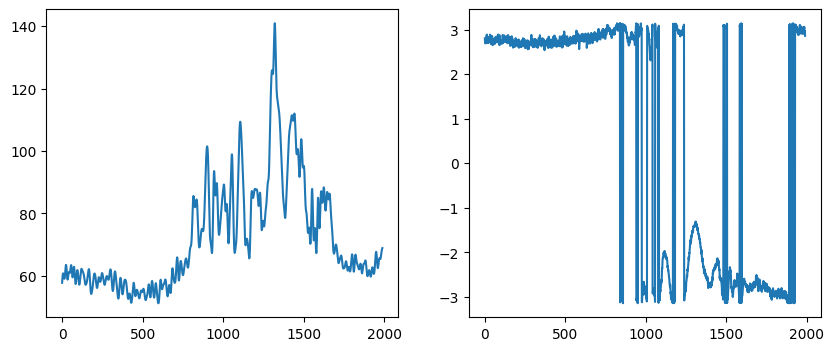

In [127]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(np.abs(H_filtered[:,0]))

plt.subplot(1,2,2)
plt.plot(np.angle(H_filtered[:,0]))

In [132]:
# =============================================
# 4. PCA降维（保留前5个主成分）
# =============================================
def pca_denoise(csi_data, n_components=5):
    """PCA降维与重构"""
    pca = PCA(n_components=n_components)
    data_real = csi_data.real.reshape(-1, csi_data.shape[1])
    data_imag = csi_data.imag.reshape(-1, csi_data.shape[1])
    # 分别对实部和虚部做PCA
    real_pca = pca.fit_transform(data_real)
    real_denoised = pca.inverse_transform(real_pca)
    imag_pca = pca.fit_transform(data_imag)
    imag_denoised = pca.inverse_transform(imag_pca)
    return real_denoised + 1j * imag_denoised
    
H_pca = pca_denoise(H_filtered, n_components=2)  # 输出形状 (1000, 57)

In [137]:
def pca(X, n_components=None, centered=True, algorithm='svd',
        weights=None, variable_weights=None, missing_rows='complete',
        economy=True, tol=1e-6):
    X = np.asarray(X)
    n, p = X.shape
    
    # ================ Missing Value Handling ================
    nan_mask = np.isnan(X).any(axis=1)
    if missing_rows == 'complete':
        valid_rows = ~nan_mask
        X_clean = X[valid_rows]
        if weights is not None:
            weights = np.asarray(weights)[valid_rows]
    else:
        raise ValueError("Only 'complete' missing value handling supported")
    
    n_clean, p_clean = X_clean.shape
    
    # ================ Weight Initialization ================
    if weights is None:
        weights = np.ones(n_clean, dtype=X.dtype)
    else:
        weights = np.asarray(weights).astype(X.dtype)
    
    # ================ Variable Weights Handling ================
    if variable_weights == 'variance':
        if not centered:
            raise ValueError("Variance weights require centering")
        # Match MATLAB's wnanvar with ddof=1
        mu_clean = np.nanmean(X_clean, axis=0)
        X_centered_clean = X_clean - mu_clean
        var = np.nansum((X_centered_clean * np.conj(X_centered_clean)) * weights.reshape(-1,1), axis=0) / (np.sum(weights) - 1)
        variable_weights = 1 / np.real(var)
    elif variable_weights is None:
        variable_weights = np.ones(p, dtype=np.float64)
    else:
        variable_weights = np.asarray(variable_weights)
    
    # ================ Data Centering ================
    if centered:
        mu = np.nansum(X_clean * weights.reshape(-1,1), axis=0) / np.sum(weights)
        X_centered = X_clean - mu
    else:
        mu = np.zeros(p, dtype=X.dtype)
        X_centered = X_clean.copy()
    
    # ================ Weight Application ================
    sqrt_weights = np.sqrt(weights).reshape(-1,1)
    sqrt_var_weights = np.sqrt(variable_weights).reshape(1,-1)
    
    X_weighted = X_centered * sqrt_weights * sqrt_var_weights
    
    # ================ SVD Decomposition ================
    U, S, Vt = svd(X_weighted, full_matrices=False)
    coeff = (Vt.T / sqrt_var_weights.reshape(-1,1)).astype(X.dtype)
    
    # ================ Scores Calculation ================
    score = U * S
    score = score / sqrt_weights
    
    # ================ Sign Convention (MATLAB Compatibility) ================
    for i in range(coeff.shape[1]):
        col = coeff[:, i]
        max_idx = np.argmax(np.abs(col))
        max_val = col[max_idx]
        phase = np.angle(max_val)
        rotation = np.exp(-1j * phase)
        coeff[:, i] = (col * rotation).astype(X.dtype)
        score[:, i] = (score[:, i] * rotation).astype(X.dtype)
    
    # ================ Variance Explained ================
    dof = n_clean - (1 if centered else 0)
    latent = (S**2) / dof if dof > 0 else np.zeros_like(S)
    
    # ================ Economy Size Handling ================
    if economy:
        max_components = min(dof, p)
        coeff = coeff[:, :max_components]
        score = score[:, :max_components]
        latent = latent[:max_components]
    
    # ================ Component Selection ================
    if n_components is not None:
        coeff = coeff[:, :n_components]
        score = score[:, :n_components]
        latent = latent[:n_components]
    
    # ================ Explained Variance ================
    total_var = np.sum(np.real(latent))
    explained = (np.real(latent) / total_var * 100) if total_var > 0 else np.zeros_like(latent)
    
    # ================ Hotelling's T-Squared ================
    effective_rank = np.sum(latent > tol * np.max(latent))
    if effective_rank > 0:
        stand_scores = score[:, :effective_rank] / np.sqrt(latent[:effective_rank])
        tsquared = np.sum(np.abs(stand_scores)**2, axis=1)
    else:
        tsquared = np.zeros(n_clean, dtype=np.float64)
    
    # ================ NaN Reinsertion ================
    full_score = np.full((n, score.shape[1]), np.nan, dtype=score.dtype)
    full_score[valid_rows] = score
    score = full_score
    
    full_tsquared = np.full(n, np.nan, dtype=np.float64)
    full_tsquared[valid_rows] = tsquared
    
    return coeff, score, latent, full_tsquared, explained, mu

In [148]:
coeff,*_ = pca(H_filtered, n_components=1)
H_pca = np.dot(H_filtered, coeff)

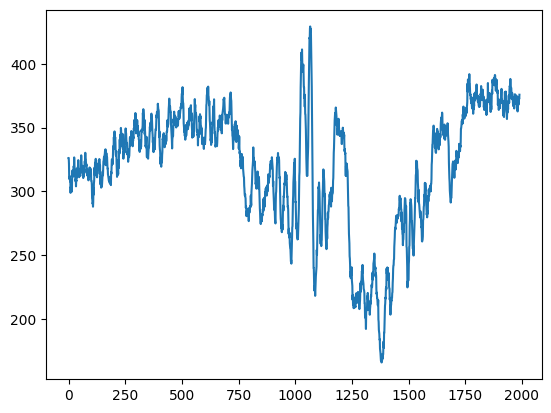

In [149]:
plt.plot(np.abs(H_pca[:,0]))

In [150]:
# =============================================
# 5. 时频分析与频谱增强（STFT + Naka-Rushton）
# =============================================
def stft_spectrogram(data, fs=1000, nperseg=125):
    """计算STFT频谱图"""
    window = windows.gaussian(nperseg, 17)
    f, t, dfs = stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=int(nperseg*0.9), axis=0)
    return f, t, dfs  # 取幅度谱

def naka_rushton_enhancement(spectrogram, r=2, patch_size=30):
    """Naka-Rushton对比度增强（式9）"""
    enhanced = np.zeros_like(spectrogram)
    for i in range(0, spectrogram.shape[0], patch_size):
        for j in range(0, spectrogram.shape[1], patch_size):
            patch = spectrogram[i:i+patch_size, j:j+patch_size]
            mu = np.mean(patch)
            enhanced_patch = (patch**r) / (patch**r + mu**r)
            enhanced[i:i+patch_size, j:j+patch_size] = enhanced_patch
    return enhanced

# 对每个子载波计算STFT并增强
f, t = None, None
spectrograms = []
for subcarrier in range(H_pca.shape[1]):
    dfs_f, dfs_t, S = stft_spectrogram(H_pca[:, subcarrier], fs=1000)
    f, t = dfs_f, dfs_t
    # S_enhanced = naka_rushton_enhancement(S, r=2)
    spectrograms.append(S)

C:\Users\20249\AppData\Local\Temp\ipykernel_16096\3763544090.py:7: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, dfs = stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=int(nperseg*0.9), axis=0)


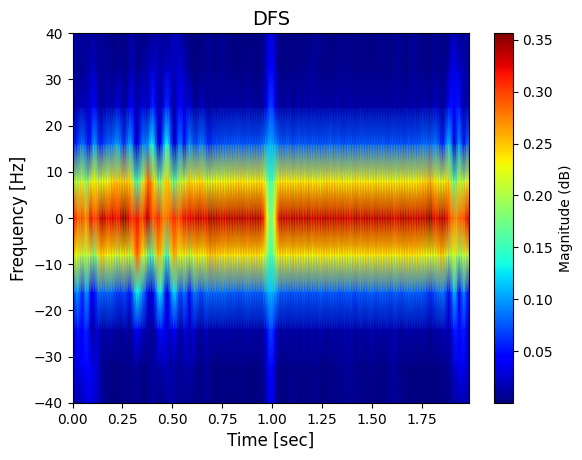

In [152]:
select_fre = (f<=40) & (f>=-40)
select_f = f[select_fre]
select_spec = np.abs(spectrograms[0])[select_fre]
select_spec = select_spec/np.sum(select_spec, axis=0)

plt.pcolormesh(t, np.fft.fftshift(select_f), np.fft.fftshift(select_spec), shading='gouraud', cmap='jet')
plt.title('DFS', fontsize=14)
plt.ylabel('Frequency [Hz]', fontsize=12)
plt.xlabel('Time [sec]', fontsize=12)
plt.colorbar(label='Magnitude (dB)')